In [2]:
using BlackBoxOptim, NLsolve, Distributions, QuadGK, Plots, LaTeXStrings, ForwardDiff, Roots

Setting a few elements that we need

In [3]:
F(x) = cdf(Truncated(Normal(0.5,1),0,1),x)
f(x) = ForwardDiff.derivative(F,x)

f (generic function with 1 method)

We need to look at the property of the following equation: Equation (11) in the latest version of the paper, the condition for informed buyer to not to pretend to be uninformed. The following is the probability of trade function for $w \in [r, \underline w)$

In [4]:
Q_eps(alpha, w, xi, n) = ((1 - alpha)*F(w) + alpha * F(xi))^(n-1)

Q_eps (generic function with 1 method)

In [5]:
chi_uninformed(n, alpha, x) = n * alpha * (1 - F(x)) * x

chi_uninformed (generic function with 1 method)

From footnote(10): The unconstrained equal priority auction is given by $(1-F(\xi))\phi(\hat w) = \pi(t)$, $r = r^*$, $\underline w = \overline w = \hat w$,  $t = \max(\xi, r)$. It is also required that $\xi < r*$

In [6]:
eqf(xi, w, t) = (1 - F(xi)) * phi(w) - t * (1 - F(t))
phi(x) = x - (1 - F(x))/f(x)

phi (generic function with 1 method)

solve in terms of xi, and then we need to plug into (11).

We first find the optimal $r*$.

In [7]:
n = 100
alpha = 0.8

function pi(x)
    return  (1 - F(x[1])) * x[1]
end
#create a negative replica since the optimizer is finding the minimum. 
pin(x) = -pi(x)
res = bboptimize(pin ; SearchRange = (0.0 , 1.0), NumDimensions = 1);
r_star = best_candidate(res)[1]

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.09 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 108387.15
Function evals per second = 109470.91
Improvements/step = 0.22900
Total function evaluations = 10101


Best candidate found: [0.489975]

Fitness: -0.250104878



0.4899748329665175

A plot of the revenue function to double-check

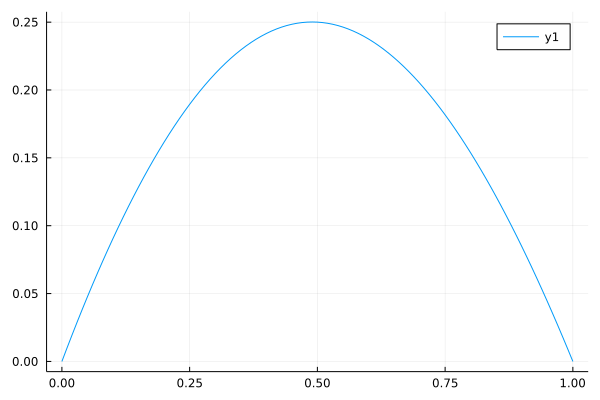

In [8]:
plot(0:0.01:1, [pi(x) for x = 0:0.01:1])

The function would not be evaluating at 1. This is because f(1) is 0. Hence we use 0.999 as the other end of the bracketing interval here, as we use are using 0.01 as the step length. Also note that $\xi \in (0,1)$

In [23]:
#calculating w_hat that satisfy the equation for unconstrained solution given xi. 
w_hat = []
for xi in 0:0.01:1
    t = max(xi, r_star)
    eqf_a(w) = eqf(xi, w, t)
    push!(w_hat, fzero(eqf_a,0,0.999))
end


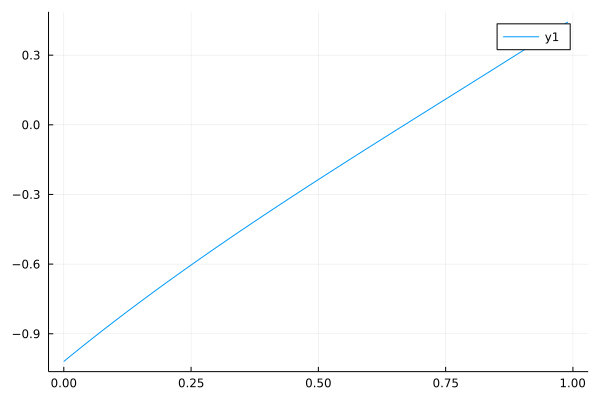

In [10]:
#an example to make sure this calculation makes sense
xi = 0.3
t = max(xi, r_star)
eqf_a(w) = eqf(xi, w, t)
w_hat = fzero(eqf_a,0,0.99)
plot(0:0.01:1, eqf_a)

$$\int_{r}^{\underline w} Q^{\epsilon}(w) dw \geq \chi \max(\underline w - t, 0) $$

In [18]:
P_informed(w,n,alpha) = (1 - F(w))^(n*alpha)
P_uninformed(xi,n,alpha) = F(xi)^(n*(1-alpha)-1)
P_trade(w,xi,n,alpha) = P_informed(w,n,alpha)*P_uninformed(xi,n,alpha)

P_trade (generic function with 1 method)

In [19]:
#trade probability for informed in pooling interval
Qeps2(xi,w,alpha)=(((1-alpha)*F(w)+alpha)^n - ((1-alpha)*F(w)+ alpha*F(xi))^n)/(alpha * (1-F(xi)))

#make adhoc lhs - rhs function
lradc(xi,w,alpha,t,Q_eps_a) = quadgk(Q_eps_a, r_star, w)[1] - P_trade(w,xi,n,alpha) * max(w - t, 0)

lradc (generic function with 1 method)

In [20]:
alpha = 0.8

0.8

An interested uninformed buyer would receive an offer when: 
1. No Informed buyer has type above $\hat w$
2. Uninformed buyers have type below $\xi$

In [24]:
xi = [i for i = 0:0.01:1]
v_lradc = []
for w in w_hat
    #one-to-one correspondence between w and xi
    ind = findall(i -> i == w, w_hat) #select the indice of w_hat 
    t_adc = max(xi[ind][1], r_star) #calculate t with the xi that corresponds to w_hat
    Q_eps_a(w) = Q_eps(alpha, w, xi[ind][1], n)
    lr_value = lradc(xi[ind][1],w,alpha,t_adc,Q_eps_a)#left-right of (11)
    push!(v_lradc, lr_value)
end

In [25]:
v_lradc

101-element Vector{Any}:
  1.242788693739404e-92
 -4.104953263754719e-74
 -1.7427381318864463e-68
 -3.1040654435923282e-65
 -5.850900161131807e-63
 -3.208735522789137e-61
 -8.032143715408617e-60
 -1.1667239034898738e-58
 -1.1347756455107114e-57
 -8.103933773222728e-57
 -4.524874884404242e-56
 -2.0655934420399212e-55
 -7.966774771497303e-55
  ⋮
  2.893837589621682e-6
  7.503321002373277e-6
  1.9211351261751507e-5
  4.85816776689829e-5
  0.00012136131983551985
  0.000299545022729118
  0.0007306287500998821
  0.0017614124857282375
  0.0041978796411516455
  0.009891829189579884
  0.02305007321520081
  0.05213255876987269

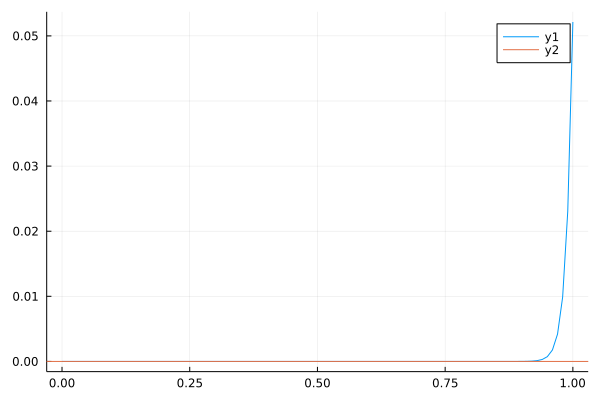

In [26]:
#alpha = 0.8, plotting LHS - RHS of (11) against xi
plot(xi, v_lradc)
hline!([0])